In [44]:
# example of training a gan on mnist
from numpy import expand_dims
from numpy import zeros
from numpy import ones
import numpy
from numpy import vstack
from keras.models import load_model
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot
from keras.utils.vis_utils import plot_model


11493376/11490434 [==============================] - 1s 0us/step
Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


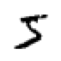

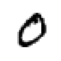

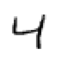

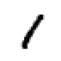

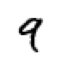

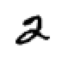

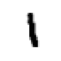

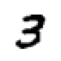

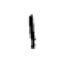

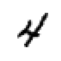

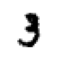

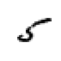

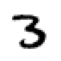

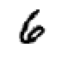

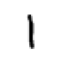

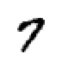

In [ ]:
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# summarize the shape of the dataset
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)


for i in range(16):
  # define subplot
  pyplot.subplot(4, 4, 1 + i)
  # turn off axis
  pyplot.axis('off')
  # plot raw pixel data
  pyplot.imshow(trainX[i], cmap='gray_r')
  pyplot.show()

In [ ]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
  model = Sequential()
  model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

model = define_discriminator()


# define the standalone generator model
def define_generator(latent_dim):
  model = Sequential()
  # foundation for 7x7 image
  n_nodes = 128 * 7 * 7
  model.add(Dense(n_nodes, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((7, 7, 128)))
  # upsample to 14x14
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # upsample to 28x28
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
  return model

def define_gan(g_model, d_model):
  d_model.trainable = False
  model = Sequential()
  # add generator
  model.add(g_model)
  model.add(d_model)
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)             

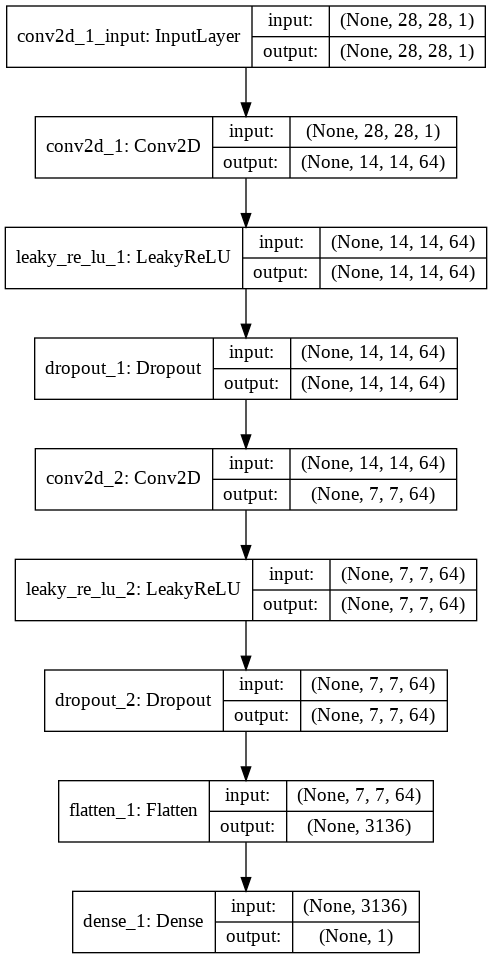

In [ ]:
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

In [42]:
def load_real_samples():
  # load mnist dataset
  (trainX, _), (_, _) = load_data()
  # expand to 3d, e.g. add channels dimension
  X = expand_dims(trainX, axis=-1)
  # convert from unsigned ints to floats
  X = X.astype('float32')
  # scale from [0,255] to [0,1]
  X = X / 255.0
  return X

def generate_real_samples(dataset, n_samples):
  ix = randint(0, dataset.shape[0], n_samples)
  X = dataset[ix]
  y = ones((n_samples, 1))
  return X, y

def generate_latent_points(latent_dim, n_samples):
  # generate points in the latent space
  x_input = randn(latent_dim * n_samples)
  # reshape into a batch of inputs for the network
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
  # generate points in latent space
  x_input = generate_latent_points(latent_dim, n_samples)
  X = g_model.predict(x_input)
  y = zeros((n_samples, 1))
  return X, y

  
def save_plot(examples,n):
  # plot images
  for i in range(n * n):
    # define subplot
    pyplot.subplot(n, n, 1 + i)
    # turn off axis
    pyplot.axis('off')
    # plot raw pixel data
    pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()
    pyplot.close()

In [ ]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
  X_real, y_real = generate_real_samples(dataset, n_samples)
  # evaluate discriminator on real examples
  acc_real = d_model.evaluate(X_real, y_real, verbose=0)
  # prepare fake examples
  x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
  # evaluate discriminator on fake examples
  acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
  # save plot
  save_plot(x_fake, epoch)
  # save the generator model tile file
  filename = 'generator_model_%03d.h5' % (epoch + 1)
  g_model.save(filename)


In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for i in range(n_epochs):
    # enumerate batches over the training set
    for j in range(bat_per_epo):
      X_real, y_real = generate_real_samples(dataset, half_batch)
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
      d_loss, _ = d_model.train_on_batch(X, y)
      X_gan = generate_latent_points(latent_dim, n_batch)
      y_gan = ones((n_batch, 1))
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
    if (i+1) % 10 == 0:
      summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

In [22]:
model.save('/content/mnist_dense.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


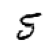

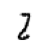

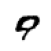

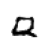

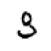

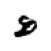

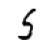

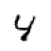

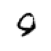

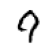

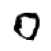

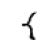

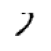

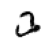

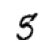

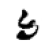

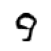

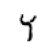

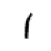

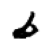

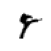

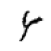

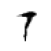

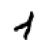

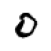

In [43]:

# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot
# load model
model = load_model('generator_model_100.h5')
# generate images
latent_points = generate_latent_points(100, 25)
# generate images
X = model.predict(latent_points)
# plot the result
save_plot(X, 5)
